# Experimenting with a simple model of Golman et al (2019) type

Here playing around with a version of the "dual accumulator model" presented in:

> Golman, R., Bhatia, S., & Kane, P. B. (2019). The dual accumulator model of strategic deliberation and decision making. *Psychological Review*. https://psycnet.apa.org/record/2019-79085-001

Briefly summarised, the Golman et al model addresses two-agent, one-shot games (like e.g., the well-known [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) etc), but instead of modelling them using game theory, Golman et al suggest a framework based on a set of interlinked evidence accumulators, effectively shortcircuiting the sequence of iterated reasoning ("I think that she thinks that I think...") into just one dynamically connected loop. They show that this type of model can explain a number of phenomena where humans do not behave in line with the perfect rationality assumptions of classical game theory. 

To just see the highlights and plots, skip to "Kreps game" further below.

## Details for the interested

In my slightly modified/generalised version of the model, the value of action $a$ for agent A is estimated as:

$\hat{V}_a(t) = \alpha\hat{V}_a(t-1) + \beta \sum_b P_b(t-1) V_{a|b}$,

and conversely, the value of action $b$ for agent B:

$\hat{V}_b(t) = \alpha\hat{V}_b(t-1) + \beta \sum_a P_a(t-1) V_{b|a}$,

where the estimated action probabilities are:

$P_a(t) = e^{\lambda \hat{V}_a(t)} / \sum_a e^{\lambda \hat{V}_a(t)}$,

and:

$P_b(t) = e^{\lambda \hat{V}_b(t)} / \sum_b e^{\lambda \hat{V}_b(t)}$.

The $V_{a|b}$ (value for A of action $a$ if B plays $b$) and $V_{b|a}$ are simply the payoffs as defined in the two-agent game under study. Larger values of the $\lambda$ parameter means that agents are more likely to choose the highest-value option; lower values suggest an agent with a greater degree of "randomness" in their decisions. Setting $\beta = 1 - \alpha$ makes $\hat{V}_a(t)$ a simple low-pass filter estimator of $V_a(t) \equiv \sum_b P_b(t) V_{a|b}(t)$, whereas Golman et al fix $\alpha = \beta = 1$ and let $\hat{V}_a(t)$ grow indefinitely.

The above is also different from the Golman et al model in that they used the $P_a(t)$ and $P_b(t)$ probabilities to randomly draw specific actions $a$ and $b$ for each agent in each time step, and update the other value accumulator according to the corresponding values $V_{b|a}$ and $V_{a|b}$, rather than taking a probability-weighted average in each time step, like above. I think the weighted average above is nice in that it makes it possible to run the model deterministically, which makes some nice features of the framework a little more obvious. (It also makes the model a little bit more like a neural network.)
## Implementation

In [1]:
import numpy as np
import math
import scipy.special
import matplotlib.pyplot as plt

def golman_generalized(VALUES_OF_A_GIVEN_B, VALUES_OF_B_GIVEN_A, \
    ALPHA, BETA, LAMBDA, SIGMA = 0, START_TIME = 0, END_TIME = 10, TIME_STEP = 0.1, \
    ACTION_NAMES_A = None, ACTION_NAMES_B = None):
    
    # get some constants and allocate arrays
    N_ACTIONS_A = VALUES_OF_A_GIVEN_B.shape[0]
    N_ACTIONS_B = VALUES_OF_B_GIVEN_A.shape[0]
    TIME_STAMPS = np.arange(START_TIME, END_TIME, TIME_STEP)
    N_TIME_STEPS = len(TIME_STAMPS)
    value_a_est = math.nan * np.ones((N_ACTIONS_A, N_TIME_STEPS))
    value_b_est = math.nan * np.ones((N_ACTIONS_B, N_TIME_STEPS))
    prob_a_est = math.nan * np.ones((N_ACTIONS_A, N_TIME_STEPS))
    prob_b_est = math.nan * np.ones((N_ACTIONS_B, N_TIME_STEPS))

    # all accumulators initialised to zero
    value_a_est[:, 0] = 0
    value_b_est[:, 0] = 0

    # simulation loop
    for i_time_step in range(N_TIME_STEPS):
        # update estimated value of actions
        if i_time_step > 0:
            for i_action_A in range(N_ACTIONS_A):
                value_a_est[i_action_A, i_time_step] = \
                    ALPHA * value_a_est[i_action_A, i_time_step-1] \
                    + BETA * np.dot(prob_b_est[:, i_time_step-1], \
                                    VALUES_OF_A_GIVEN_B[i_action_A, :] \
                                    + np.random.randn(N_ACTIONS_B) * SIGMA)
            for i_action_B in range(N_ACTIONS_B):
                value_b_est[i_action_B, i_time_step] = \
                    ALPHA * value_b_est[i_action_B, i_time_step-1] \
                    + BETA * np.dot(prob_a_est[:, i_time_step-1], \
                                    VALUES_OF_B_GIVEN_A[i_action_B, :] \
                                    + np.random.randn(N_ACTIONS_A) * SIGMA)
        # update action probabilities
        prob_a_est[:, i_time_step] = scipy.special.softmax(LAMBDA * value_a_est[:, i_time_step])
        prob_b_est[:, i_time_step] = scipy.special.softmax(LAMBDA * value_b_est[:, i_time_step])

    # plotting
    # - legends
    if ACTION_NAMES_A is None:
        action_names_a = []
        for i in range(N_ACTIONS_A):
            action_names_a.append(str(i))
    else:
        action_names_a = ACTION_NAMES_A
    if ACTION_NAMES_B is None:
        action_names_b = []
        for i in range(N_ACTIONS_B):
            action_names_b.append(str(i))
    else:
        action_names_b = ACTION_NAMES_B
    # - estimated values
    # -- agent A
    plt.subplot(2, 2, 1)
    plt.plot(TIME_STAMPS, value_a_est.T)
    plt.title('A')
    plt.ylabel('$\hat{V}(action)$ (-)')
    plt.legend(action_names_a)
    # -- agent B
    plt.subplot(2, 2, 2)
    plt.plot(TIME_STAMPS, value_b_est.T)
    plt.title('B')
    plt.legend(action_names_b)
    # - probabilities
    # -- agent A
    plt.subplot(2, 2, 3)
    plt.plot(TIME_STAMPS, prob_a_est.T)
    plt.ylim(-.1, 1.1)
    plt.ylabel('$P(action)$ (-)')
    plt.xlabel('Time (arb. units)')
    # -- agent B
    plt.subplot(2, 2, 4)
    plt.plot(TIME_STAMPS, prob_b_est.T)
    plt.ylim(-.1, 1.1)
    plt.xlabel('Time (arb. units)')

## Kreps game

This is one of the games analysed by Golman et al, with payoff matrix:
 
| A \ B | Left | Middle | Non-Nash | Right |
|:-:|:-:|:-:|:-:|:-:|
| **Top** | 100 \ 70 | 60 \ 69 | 62 \ 66 | 64 \ 10 |
| **Bottom** | 60 \ 10 | 62 \ 40 | 66 \ 66 | 70 \ 68 |

The Nash equilibria (which rational decision-makers should prefer) are "top left" and "bottom right", but human players B often choose the "non-Nash" option, presumably to avoid the risk of getting the very low payoff of 10 if A chooses the "wrong" Nash equilibrium option.

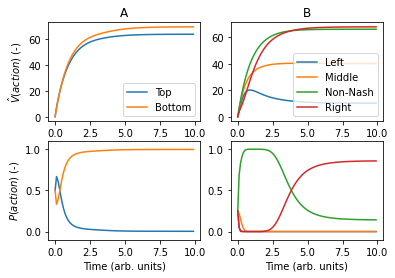

In [2]:
ACTION_NAMES_A = ('Top', 'Bottom')
ACTION_NAMES_B = ('Left', 'Middle', 'Non-Nash', 'Right')
VALUES_OF_A_GIVEN_B = np.array([[100, 60, 62, 64], [60, 62, 66, 70]])
VALUES_OF_B_GIVEN_A = np.array([[70, 69, 66, 10], [10, 40, 66, 68]]).T
ALPHA = 0.9
BETA = 1 - ALPHA
LAMBDA = 1
golman_generalized(VALUES_OF_A_GIVEN_B, VALUES_OF_B_GIVEN_A, ALPHA, BETA, LAMBDA, \
    ACTION_NAMES_A = ACTION_NAMES_A, ACTION_NAMES_B = ACTION_NAMES_B)

The $\hat{V}$ plots above show how the agents estimate the value of the different actions. In this noise-free model variant, the top left plot shows both how A values its own options, and how B thinks A values them. In the Golman et al model with noise, those two things (A's value estimates, and B's estimates of A's value estimates) can diverge.

In the specific simulation above, A converges on preferring "Bottom", which leads to B first preferring "Non-Nash", but given enough time for deliberation B realises that "Right" is a better option.

If setting the $\lambda$ parameter to a lower value, indicating a larger expected randomness in the opponent, we can instead get B to prefer the safer, non-Nash option, in line with the experimental findings:

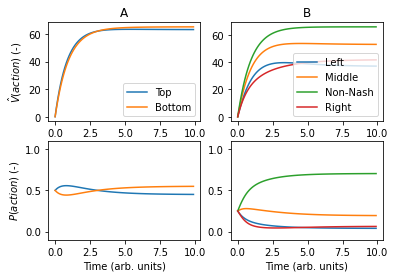

In [3]:
LAMBDA = 0.1
golman_generalized(VALUES_OF_A_GIVEN_B, VALUES_OF_B_GIVEN_A, ALPHA, BETA, LAMBDA, \
    ACTION_NAMES_A = ACTION_NAMES_A, ACTION_NAMES_B = ACTION_NAMES_B)

With a more Golman-type accumulation, we get the same qualitative outcome, but in this case in fewer time steps:

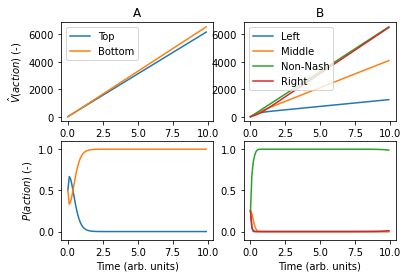

In [4]:
ALPHA = 1
BETA = 1
golman_generalized(VALUES_OF_A_GIVEN_B, VALUES_OF_B_GIVEN_A, ALPHA, BETA, LAMBDA, \
    ACTION_NAMES_A = ACTION_NAMES_A, ACTION_NAMES_B = ACTION_NAMES_B)

## Travellers dilemma

In this game, also studied by Golman et al, the story is that two travellers have lost identical pieces of luggage, and must both individually tell the airline how much it was worth. They both get paid the lowest value of their two claims, but if the agents claimed different values, the agent with the lower claim gets bumped up a level as a premium and the one with the higher claim gets bumped down a level as a penalty. The Nash equilibrium is for both agents to try to undercut each other all the way to the bottom, i.e., perfectly rational agents should both claim the lowest possible value.

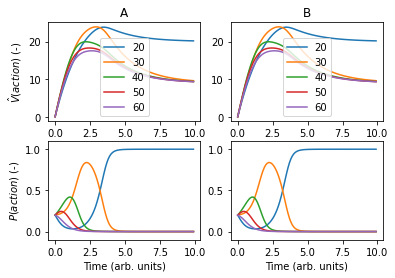

In [5]:
# get payoff matrix   
MIN_BID = 20
MAX_BID = 60
BID_INT = 10
GAMMA = 11
BIDS = np.arange(MIN_BID, MAX_BID+BID_INT, BID_INT)
N_BIDS = len(BIDS)
VALUES = np.zeros((N_BIDS, N_BIDS))
for i_bid_A, bid_A in enumerate(BIDS):
    for i_bid_B, bid_B in enumerate(BIDS):
        if bid_A == bid_B:
            delta = 0
        else:
            delta = math.copysign(GAMMA, bid_B - bid_A)
        VALUES[i_bid_A, i_bid_B] = min(bid_A, bid_B) + delta
        
# model settings
ALPHA = 0.95
BETA = 1 - ALPHA
LAMBDA = 1

# run model
golman_generalized(VALUES, VALUES, ALPHA, BETA, LAMBDA, \
    ACTION_NAMES_A = BIDS, ACTION_NAMES_B = BIDS) # symmetric game - same value matrices for both players

Note above how the model really nicely "argues" itself down to the Nash equilibrium. "If I do this, then the other guy should do that, but hey in that case I should do this instead, ..." and so on.

Again, setting a lower $\lambda$, increasing the expected randomness in the decisions, results in intermediate, non-Nash, actions coming out on top:

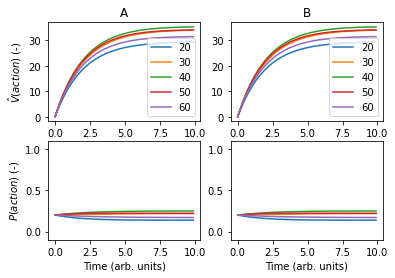

In [6]:
LAMBDA = 0.1
golman_generalized(VALUES, VALUES, ALPHA, BETA, LAMBDA, \
    ACTION_NAMES_A = BIDS, ACTION_NAMES_B = BIDS)

## Conclusion

The Golman et al model is really cool! From the figures above one can follow the model "thinking" through its decision in a rather fascinating way. In this sense, it really is a model of "deliberation" as stated in the paper title, but I find this aspect of it pops out more clearly in these deterministic simulations than in the figures in the paper.

Also the "low-pass filtered estimation of value" formulation I used here might be handy for some applications.